# Plate with a Hole

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/adtzlr/felupe-web/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fadtzlr%252Ffelupe%26urlpath%3Dlab%252Ftree%252Ffelupe%252Fdocs%252Fexamples%252Fplatewithhole.ipynb%26branch%3Dmain)

```{admonition} Plane stress structural linear analysis.
* create and mesh a plate with a hole

* define a solid body with a linear-elastic plane stress material

* create an external pressure load

* export and plot stress results
```

A plate with length $2L$, height $2h$ and a hole with radius $r$ is subjected to a uniaxial tension $p=-100$ MPa. What is being looked for is the von Mises stress distribution and the concentration of normal stress $\sigma_{11}$ over the hole.

<img src=images/platewithhole.svg alt= “platewithhole” width="400px">

In [ ]:
h = 1
L = 2
r = 0.3

Let's create a meshed plate with a hole out of quad cells, either by FElupe or with the help of `pygmsh` (install with `pip install pygmsh`). Only a quarter model of the plate is considered.

The mesh generation in FElupe is carried out by filling the area between the edge of the hole and the top line. Then, this section is duplicated, mirrored and merged with another rectangle.

In [ ]:
import felupe as fem
import numpy as np

phi = np.linspace(1, 0.5, 21) * np.pi / 2

line = fem.mesh.Line(n=21)
curve = line.copy(points=r * np.vstack([np.cos(phi), np.sin(phi)]).T)
top = line.copy(points=np.vstack([np.linspace(0, h, 21), np.linspace(h, h, 21)]).T)

face = curve.fill_between(top, n=21)
rect = fem.mesh.Rectangle(a=(h, 0), b=(L, h), n=(21, 21))
mesh = fem.mesh.concatenate([face, face.mirror(normal=[-1, 1, 0]), rect]).sweep()

<img src=images/platewithhole_mesh_felupe.png alt="mesh-platewithhole-felupe" width="400px">

 The second mesh generation method uses `pygmsh`. A boolean difference between a rectangle and a disk results in a plate with a hole. This plate is meshed with triangles. A so-called *re-combination* of the surface mesh gives a mesh with quad cells.

In [ ]:
import pygmsh

with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_min = 0.02
    geom.characteristic_length_max = 0.02

    rectangle = geom.add_rectangle([0, 0, 0], L, h)
    disk = geom.add_disk([0, 0, 0], r)

    plate = geom.boolean_difference(rectangle, disk)

    geom.set_recombined_surfaces(plate)
    mesh = geom.generate_mesh()

The points and cells of the above mesh are used to initiate a FElupe mesh.

In [ ]:
mesh = fem.Mesh(
    points=mesh.points[:, :2], cells=mesh.cells[1].data, cell_type=mesh.cells[1].type
)

<img src=images/platewithhole_mesh.png alt="mesh-platewithhole" width="400px">

A numeric quad-region created on the mesh in combination with a vector-valued displacement field represents the plate. The Boundary conditions for the symmetry planes are generated on the displacement field.

In [ ]:
region = fem.RegionQuad(mesh)
displacement = fem.Field(region, dim=2)
field = fem.FieldContainer([displacement])

boundaries = fem.dof.symmetry(displacement)

The material behaviour is defined through a built-in isotropic linear-elastic material formulation for plane stress problems. A solid body applies the linear-elastic material formulation on the displacement field.

In [ ]:
umat = fem.LinearElasticPlaneStress(E=210000, nu=0.3)
solid = fem.SolidBody(umat, field)

The external uniaxial tension is applied by a pressure load on the right end at $x=L$. Therefore, a boundary region in combination with a field has to be created at $x=L$.

In [ ]:
region_boundary = fem.RegionQuadBoundary(mesh, mask=mesh.points[:, 0] == L)
field_boundary = fem.FieldContainer([fem.Field(region_boundary, dim=2)])

load = fem.SolidBodyPressure(field_boundary, pressure=-100)

The equivalent stress von Mises, projected to mesh points, will be added to the result file. For the two-dimensional case it is calculated by

$$ \sigma_{vM} = \sqrt{\sigma_{11}^2 + \sigma_{22}^2 + 3 \ \sigma_{12}^2 + \sigma_{11} \ \sigma_{22}} ~ .$$

In [ ]:
import numpy as np


def von_mises(field, **kwargs):
    "Von Mises Stress projected to mesh points."

    stress = solid.evaluate.gradient(field)[0]

    vonmises = np.sqrt(
        stress[0, 0] ** 2
        + stress[1, 1] ** 2
        + 3 * stress[0, 1] ** 2
        + stress[0, 0] * stress[1, 1]
    )

    return fem.project(vonmises, region)

The simulation model is now ready to be solved. The results are saved within a XDMF-file, where additional point-data is passed to the `point_data` argument. 

In [ ]:
step = fem.Step(items=[solid, load], boundaries=boundaries)
job = fem.Job(steps=[step])
job.evaluate(filename="result.xdmf", point_data={"von Mises Stress": von_mises})

The stress distribution may be viewed either by opening the XDMF time-series file in ParaView or by creating a view on the field-container directly inside the notebook.

In [ ]:
view = fem.View(field, point_data={"von Mises Stress": von_mises(field)})
plotter = view.plot("von Mises Stress", show_edges=False)
plotter.show(jupyter_backend="panel")

![](images/platewithhole_stress_continuous_alpha.png)

The normal stress distribution over the hole at $x=0$ is plotted with matplotlib.

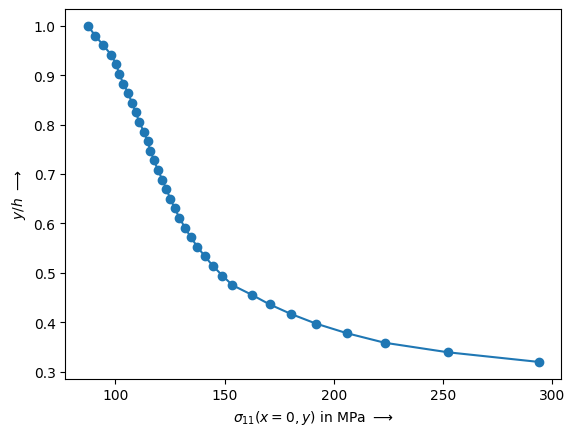

In [ ]:
import matplotlib.pyplot as plt

left = mesh.points[:, 0] == 0

plt.plot(
    fem.tools.project(solid.results.stress[0], region)[:, 0][left],
    mesh.points[:, 1][left] / h,
    "o-",
)

plt.xlabel(r"$\sigma_{11}(x=0, y)$ in MPa $\longrightarrow$")
plt.ylabel(r"$y/h$ $\longrightarrow$");